# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

#Hyperparameter tuning
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

#Estimator
from sagemaker.pytorch import PyTorch

#Debugger and Profiler
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

#Plotting Debug Report
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#Display Profiler Report
import os
import IPython

#Import Data for Query
import gzip 
import numpy as np
import random
import os

#Setup
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/project-pytorch-cifar"

role = sagemaker.get_execution_role()

[2022-01-23 14:44:46.857 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3
from torchvision import transforms
from torchvision.datasets import CIFAR10


local_dir = 'data'
CIFAR10.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/CIFAR10/"]
CIFAR10(
    local_dir,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

inputs = sagemaker_session.upload_data(path=local_dir, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

# # Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

Files already downloaded and verified
input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-690938509668/sagemaker/project-pytorch-cifar


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([10, 32]),
}

In [6]:
#TODO: Create estimators for your HPs
# rules = [
#     Rule.sagemaker(rule_configs.loss_not_decreasing()),
#     ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
#     Rule.sagemaker(rule_configs.vanishing_gradient()),
#     Rule.sagemaker(rule_configs.overfit()),
#     Rule.sagemaker(rule_configs.overtraining()),
#     Rule.sagemaker(rule_configs.poor_weight_initialization()),
# ]
# profiler_config = ProfilerConfig(
#     system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
# )
# debugger_config = DebuggerHookConfig(
#     hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
# )
estimator = PyTorch(
    entry_point="./train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
#     hyperparameters={"epochs": "2", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"},
    instance_count=1,
    instance_type="ml.m5.large",
#     profiler_config = profiler_config,
#     debugger_hook_config = debugger_config,
#     rules = rules
)# TODO: Your estimator here

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{
    "Name": "average test loss",
    "Regex": "Testing Loss: ([0-9\\.]+)"
}]
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)# TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True) # TODO: Remember to include your data channels

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-220123-0718


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# TODO: Get the best estimators and the best HPs
# best_training_name = 'pytorch-training-220123-0718'
# tuner.attach(best_training_name)
best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'epochs': '"2"',
 'batch-size': '"32"',
 'test-batch-size': '"100"',
 'lr': '"0.001"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [11]:
# TODO: Create and fit an estimator

estimator = best_estimator# TODO: Your estimator here
estimator.profiler_config = profiler_config
estimator.debugger_hook_config = debugger_config
estimator.rules = rules
estimator.fit({"training":inputs}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pytorch-training-2022-01-23-11-15-52-475


2022-01-23 11:15:52 Starting - Starting the training job...
2022-01-23 11:16:23 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2022-01-23 11:17:23 Starting - Preparing the instances for training.........
2022-01-23 11:18:45 Downloading - Downloading input data...
2022-01-23 11:19:23 Training - Downloading the training image...
2022-01-23 11:19:48 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-23 11:19:50,234 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-23 11:19:50,236 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-23 11:19:50,245 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-23 11:19:50,251 sagemaker_pytorch_container.training INFO     Invoki

[2022-01-23 13:54:56.943 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:30 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-690938509668/pytorch-training-2022-01-23-11-15-52-475/debug-output
[2022-01-23 13:54:57.824 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:30 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-23 13:54:58.845 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:30 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


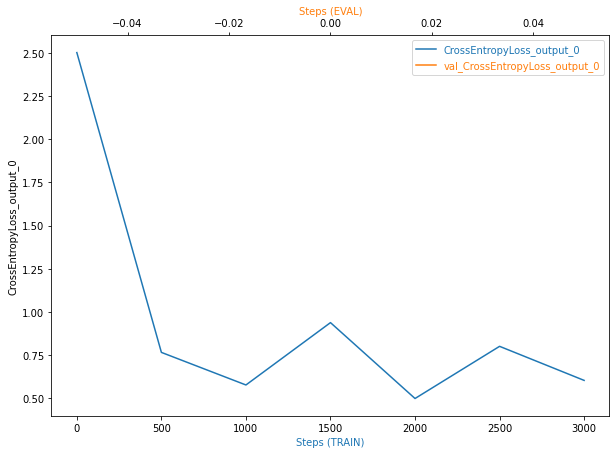

In [15]:
# TODO: Plot a debugging output.
ob_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")
    
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, trial.tensor_names()[0])

# TODO: Can you print the names of all the tensors that were tracked
# TODO: Can you print the number of datapoints for one of those tensors
# for both train and eval mode
# print(trial.tensor_names())
# len(trial.tensor(trial.tensor_names()[1]).steps(mode=ModeKeys.TRAIN))
# len(trial.tensor(trial.tensor_names()[1]).steps(mode=ModeKeys.EVAL))

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [16]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2022-01-23 13:26:43     386676 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-23 13:26:42     236704 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-23 13:26:38        193 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-23 13:26:38        201 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-23 13:26:38       1981 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-23 13:26:38        127 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-23 13:26:38        200 pytorch-training-2022-01-23-11-15-52-475/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying

In [ ]:
estimator = sagemaker.estimator.Estimator.attach('pytorch-training-2022-01-23-11-15-52-475')

In [23]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
pytorch_model = PyTorchModel(model_data=estimator.model_data, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
# predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
# TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-inference-2022-01-23-16-55-43-533
INFO:sagemaker:Creating endpoint with name pytorch-inference-2022-01-23-16-55-43-812


----------!

In [79]:
import gzip 
import numpy as np
import random
import os
from PIL import Image
import io

file = 'data/cifar-10-batches-py/data_batch_1'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

data=unpickle(file)
data=np.reshape(data[b'data'][0], (32, 32, 3), order='F')
im = Image.fromarray(data,mode='RGB')

byteImgIO = io.BytesIO()
im.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()

response=predictor.predict(byteImg, initial_args={"ContentType": "image/jpeg"})
# Image.open(io.BytesIO(byteImg))
response

[[-5.169491291046143,
  -6.202470302581787,
  -0.9620609879493713,
  1.0111072063446045,
  -0.5102508664131165,
  0.9261091351509094,
  -1.8813263177871704,
  -2.796095848083496,
  -5.250538349151611,
  -6.528252124786377]]

In [82]:
import torch
np.argmax(response, 1)

array([3])

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()